In [53]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
df = pd.read_csv('rbess_features_val.csv', index_col = 'accounts addresses')

In [3]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,predictor
accounts addresses,,,,,,,,,,,,,,,,
103,257.60,252.63,277.98,276.22,281.88,280.55,34,32541,176525,526.11,532.89,476.92,490.43,451.38,471.29,1
616,126.85,111.16,265.39,267.40,280.57,279.35,3,1897,92166,331.61,328.51,471.94,489.86,456.02,474.70,1
9,267.50,268.45,280.59,278.13,281.85,280.47,94,69558,210184,469.86,491.67,457.03,474.64,452.14,471.63,1
424,50.32,458.47,273.52,271.78,279.91,278.93,1,1454,78784,150.50,414.39,499.87,520.01,455.46,473.62,1
38,272.70,270.47,279.91,278.93,281.93,280.74,111,77330,214882,503.03,520.97,455.46,473.62,451.73,471.88,1


In [4]:
X = df.iloc[:, :-1]
y = df['predictor']

In [5]:
# Для оценки качества полученной классификации рассмотрим матрицу ошибок.
"""
    Функция conf_matrix для расчета TP (true positives), FP (false positives), TN (true negatives), FN (false negatives)  
    y_true: массив array, истинные отклики
    y_true: массив array, предсказанные классификатором отклики
"""

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels = ['Не мошенник', 'Мошенник'])
    disp.plot(cmap='Greens')
    plt.rcParams["axes.grid"] = False
    font = {'size' : 12}
    plt.rc('font', **font)
    plt.show()

In [6]:
# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 21)

In [7]:
#  Стандартизация предикторов
scaler = StandardScaler()   #   среднее 0, ст.отклонение 1

scaler.fit(X_train)

#  Важно: одинаковые параметры стандартизации у обучающего и тестового множества!
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [42]:
"""
    Функция error_rate для расчета точности классификации методом k ближайших соседей
    begin: число int, начальное значение числа k
    end: число int, конечное значение числа k
    step: число int, значение шага при переборе k
"""
def error_rate(begin, end, step):
    error_rate = []
    for i in range(begin, end, step):  
        knn_res = KNeighborsClassifier(n_neighbors=i, p = 1, weights = 'distance' )
        knn_res.fit(X_train, y_train)
        pred_i = knn_res.predict(X_test)
        error_rate.append(np.mean(pred_i != y_test))
    return error_rate

In [43]:
begin, end, step = 1, 50, 2
err_rate = error_rate(begin, end, step)

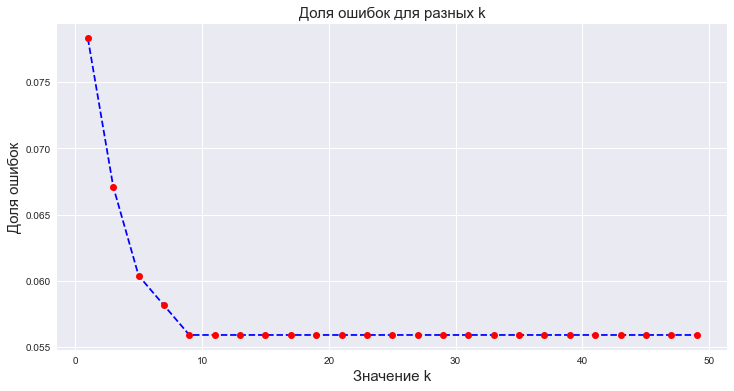

In [44]:
# Построим график
plt.figure(figsize=(12, 6))  
plt.plot(range(begin, end, step), err_rate, color='blue', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=7) 

plt.title(u'Доля ошибок для разных k', fontsize = 15)  
plt.xlabel('Значение k', fontsize = 15)  
plt.ylabel('Доля ошибок', fontsize = 15)  
plt.grid()

In [45]:
"""
    Функция recall_rate для расчета метрики recall классификации методом k ближайших соседей
    begin: число int, начальное значение числа k
    end: число int, конечное значение числа k
    step: число int, значение шага при переборе k
"""
def recall_rate(begin, end, step):
    recall_rate = []
    for i in range(begin, end, step):  
        knn_res = KNeighborsClassifier(n_neighbors=i, p = 1, weights = 'distance' )
        knn_res.fit(X_train, y_train)
        pred_i = knn_res.predict(X_test)
        recall_rate.append(recall_score(y_test, pred_i, average='macro'))
    return recall_rate

In [46]:
begin, end, step = 1, 50, 2
rec_rate = recall_rate(begin, end, step)

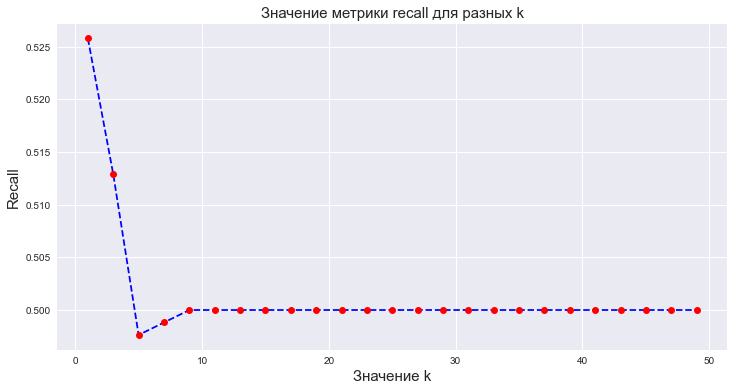

In [47]:
plt.figure(figsize=(12, 6))  
plt.plot(range(begin, end, step), rec_rate, color='blue', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=7) 

plt.title('Значение метрики recall для разных k', fontsize = 15)  
plt.xlabel('Значение k', fontsize = 15)  
plt.ylabel('Recall', fontsize = 15)  
plt.grid()

In [48]:
n_neigh = 10
clf = KNeighborsClassifier(n_neighbors = 1, 
        algorithm = 'auto',   #  как искать ближайших соседей?
        leaf_size = 30,       #  параметр  BallTree или KDTree
        metric = 'minkowski', #  расстояние между объектами
        p = 1,                #  так расст. Минковского  превращается в евклидово
        metric_params = None, #  используем для самодельных расстояний
        n_jobs = 1,           #  число процессов
        weights = 'distance')  # одинаковые веса классов

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

На тестовой выборке:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       433
           1       0.08      0.14      0.10        14

    accuracy                           0.92       447
   macro avg       0.53      0.54      0.53       447
weighted avg       0.94      0.92      0.93       447



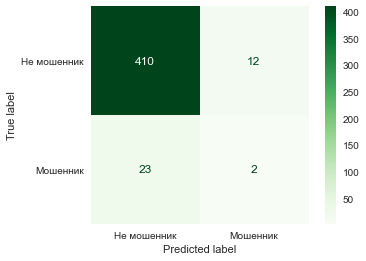

In [49]:
print('На тестовой выборке:')
print(classification_report(y_pred_test, y_test))
conf_matrix(y_test, y_pred_test)

In [67]:
estimator_KNN = KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'n_neighbors': (1,2, 10 ),
    'leaf_size': (20,40,1, 30,10),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}

In [68]:
grid_CV = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'recall',
    cv = StratifiedKFold(n_splits=5)
)
grid_CV.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': (20, 40, 1, 30, 10),
                         'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': (1, 2, 10), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             scoring='recall')

In [69]:
#   Лучший набор значений гиперпараметров
best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


In [70]:
best_model = grid_CV.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

На тестовой выборке:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       433
           1       0.08      0.14      0.10        14

    accuracy                           0.92       447
   macro avg       0.53      0.54      0.53       447
weighted avg       0.94      0.92      0.93       447



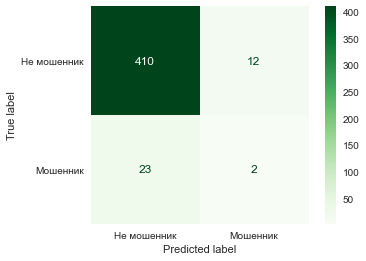

In [71]:
print('На тестовой выборке:')
print(classification_report(y_pred_test, y_test))
conf_matrix(y_test, y_pred_test)